# Face Recognition System Simulation

In this document, we provide a simple simulation of a face recognition system for testing accuracy of our generator

## 1. Load everything needed

In [138]:
# System imports
import random
import sys
import os
import logging
import json
from typing import Tuple
from pathlib import Path

# Typing imports
from typing import TypeAlias, Dict, List

# Machine learning-related libraries
import numpy as np
import tensorflow as tf
import sklearn
from sklearn.decomposition import PCA

# Graphics packages
import matplotlib
from matplotlib import pyplot
from mpl_toolkits import mplot3d
import pandas as pd
import seaborn as sn
from tabulate import tabulate

# Setting float precision
np.set_printoptions(precision=3)

In [2]:
from importlib import reload
from IPython.display import display, Markdown

reload(logging)
logging.basicConfig(stream=sys.stdout, format='',
                level=logging.INFO, datefmt=None)
log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def display_header(text: str) -> None:
    """
    Display a header 
    """
    display(Markdown(f'### {text}'))

In [3]:
def show_images(X: list, y: list, size: tuple = (9,9)) -> None:
    """
    Helper function displaying a set of specified images and their labels
    """
    assert len(X) == len(y), "X and y must have the same shapes"
    n = len(X)
    
    rows = int(np.sqrt(n))
    cols = n // rows
    
    fig, axs = pyplot.subplots(nrows=rows, ncols=cols, figsize=size)
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(X[i], cmap=pyplot.get_cmap('gray'))
        ax.set_title(f'Number {y[i]}')
    
    fig.tight_layout()
    pyplot.show()

## 2. Import MNIST dataset and display images for debugging

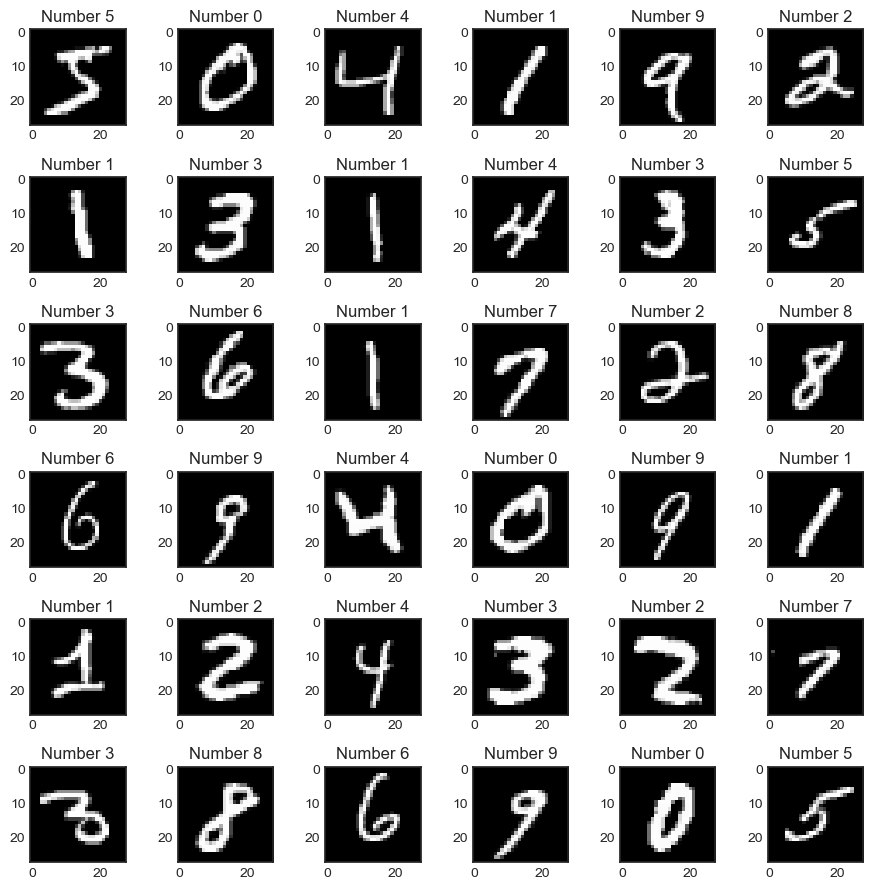

In [4]:
from keras.datasets import mnist

# Loading the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

X = X / 255.0
X = tf.expand_dims(X, axis=-1)

# Displaying example images
show_images(X[:36], y[:36])

# Forming batches with the same label
X_batches = [[np.array(X, dtype=np.float32) for X, y in zip(X, y) if y == digit] for digit in range(10)]

## 3. Evaluating mean-squared differences

Loading an embedding model:

In [5]:
EMBEDDING_MODEL_PATH = 'models/embedding/v1'
embedding_model = tf.keras.models.load_model(EMBEDDING_MODEL_PATH)
embedding_model._name = 'embedding'
embedding_model.trainable = False
embedding_model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden_layer (Dense)        (None, 2048)              1607680   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2048)              0         
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
 unit_normalization (UnitNor  (None, 10)               0         
 malization)                                                     
                                                                 
Total params: 1,628,170
Trainable params: 0
Non-trainable params: 1,628,170
_______________________________________________

Loading a generator model:

In [6]:
GENERATOR_MODEL_PATH = 'models/generator/v1.6'
generator_model = tf.keras.models.load_model(GENERATOR_MODEL_PATH)
generator_model._name = 'embedding'
generator_model.trainable = False
generator_model.summary()

Model: "embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 28, 28, 64)   640         ['input_2[0][0]']                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 28, 28, 64)   36928       ['conv2d_10[0][0]']              
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 64)  0           ['conv2d_11[0][0]']              
                                                                                          

Generating distorted images:

In [10]:
X_generated = generator_model.predict(X, verbose=1)
X_emb_real = embedding_model.predict(X, verbose=1)

2188/2188 [==============================] - 4s 2ms/step


Finding mean-squared difference between true-generated images:

In [11]:
def MSEImageLoss(y_true: any, y_pred: any) -> float:
    """
    Loss function for image comparison
    """
    
    return tf.reduce_mean(tf.math.square(y_true - y_pred))

unique_labels = np.unique(y)
X_batches_real, X_batches_generated = {}, {}
for y_unique in unique_labels:
    batch_real = np.array([X[i] for i in range(len(y)) if y[i] == y_unique])
    batch_generated = np.array([X_generated[i] for i in range(len(y)) if y[i] == y_unique])
    
    X_batches_real[y_unique] = batch_real
    X_batches_generated[y_unique] = batch_generated
    
for digit in range(10):
    loss = MSEImageLoss(X_batches_real[digit], X_batches_generated[digit])
    logging.info('Loss between real and generated digits of {} is {:.3f}'.format(digit, loss))

Loss between real and generated digits of 0 is 0.791
Loss between real and generated digits of 1 is 0.886
Loss between real and generated digits of 2 is 0.850
Loss between real and generated digits of 3 is 0.850
Loss between real and generated digits of 4 is 0.773
Loss between real and generated digits of 5 is 0.843
Loss between real and generated digits of 6 is 0.826
Loss between real and generated digits of 7 is 0.845
Loss between real and generated digits of 8 is 0.838
Loss between real and generated digits of 9 is 0.800


Defining a pair picker:

In [12]:
class PairPicker:
    """
    Class for picking the same digits
    """
    
    def __init__(self, X: list, y: list) -> None:
        """
        Initializes the PairPicker class
        
        Args:
            (X, y) - dataset
        """
        unique_labels = np.unique(y)
        self._X_batches = {}
        for y_unique in unique_labels:
            batch = [X[i] for i in range(len(y)) if y[i] == y_unique]
            self._X_batches[y_unique] = batch
        
    def pick(self, digit: int) -> Tuple[tf.Tensor, tf.Tensor]:
        """
        Picks a pair of the specified digit
        """
        digits = self._X_batches[digit]
        return random.choice(digits), random.choice(digits)
    
pair_picker_real = PairPicker(X, y)
pair_picker_generated = PairPicker(X_generated, y)

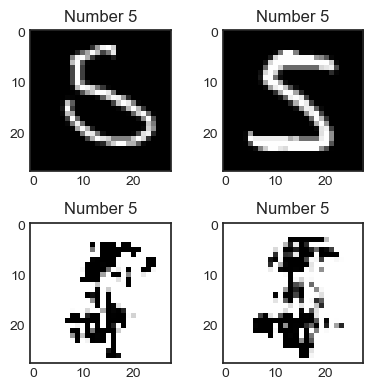

In [13]:
X1, X2 = pair_picker_real.pick(5)
X3, X4 = pair_picker_generated.pick(5)

show_images([X1, X2, X3, X4], [5]*4, size=(4,4))

In [14]:
for digit in range(10):
    avg_loss = np.mean([MSEImageLoss(*pair_picker_real.pick(digit)) for _ in range(1000)])
    logging.info('Average loss between real images of digit {} is {:.3f}'.format(digit, avg_loss))
    
for digit in range(10):
    avg_loss = np.mean([MSEImageLoss(*pair_picker_generated.pick(digit)) for _ in range(1000)])
    logging.info('Average loss between generated images of digit {} is {:.3f}'.format(digit, avg_loss))

Average loss between real images of digit 0 is 0.127
Average loss between real images of digit 1 is 0.060
Average loss between real images of digit 2 is 0.129
Average loss between real images of digit 3 is 0.113
Average loss between real images of digit 4 is 0.104
Average loss between real images of digit 5 is 0.121
Average loss between real images of digit 6 is 0.112
Average loss between real images of digit 7 is 0.094
Average loss between real images of digit 8 is 0.116
Average loss between real images of digit 9 is 0.099
Average loss between generated images of digit 0 is 0.083
Average loss between generated images of digit 1 is 0.031
Average loss between generated images of digit 2 is 0.106
Average loss between generated images of digit 3 is 0.106
Average loss between generated images of digit 4 is 0.047
Average loss between generated images of digit 5 is 0.105
Average loss between generated images of digit 6 is 0.058
Average loss between generated images of digit 7 is 0.064
Averag

## 4. Build a digit recognition system

Now, we create the sample digit recognition system.

In [85]:
UserId: TypeAlias = int

class DigitRecognitionSystem:
    """
    Mock of a face recognition system
    """
    
    LOGIN_FAILED: UserId = -1
    
    def __init__(self, generator: tf.keras.Model, embedding: tf.keras.Model, threshold: float) -> None:
        """
        Creates a simple implementation of a digit recognition system
        
        Args:
            generator - model of the generator
            threshold - threshold above which two images are considered to be different
        """
        self._threshold = threshold
        self._generator = generator
        self._embedding = embedding
        
        # Variables for storage
        self._storage: Dict[UserId, tf.Tensor] = {}
        self._last_key: UserId = 0
     
    def set_threshold(self, new_threshold: float) -> None:
        """
        Sets a new threshold for classification
        """
        self._threshold = new_threshold
    
    def register(self, photo: tf.Tensor) -> UserId:
        """
        Register a digit with the specified photo after distorting it
        
        Args:
            photo - digit photo
            
        Returns:
            User ID assigned to the specified photo
        """
        self._last_key = self._last_key + 1
        distorted_img = self._generator(np.expand_dims(photo, axis=0))
        self._storage[self._last_key] = self._embedding(distorted_img)
        return self._last_key
        
    @staticmethod
    def _distance(x: tf.Tensor, y: tf.Tensor) -> float:
        """
        Finds distance between two embeddings
        """
        return tf.square(tf.norm(y - x))
    
    def login(self, photo: tf.Tensor) -> UserId:
        """
        Tries to login into the system having a photo
        """
        
        embedding_input = self._embedding(tf.expand_dims(photo, axis=0))
        return self.login_via_embedding(embedding_input)
    
    def login_via_embedding(self, photo_embedding: tf.Tensor) -> UserId:
        if np.shape(photo_embedding)[0] != 1:
            photo_embedding = tf.expand_dims(photo_embedding, axis=0)
        
        for user_id, storage_embedding in self._storage.items():
            distance = self._distance(photo_embedding, storage_embedding)
            if distance < self._threshold:
                return user_id
            
        return DigitRecognitionSystem.LOGIN_FAILED


However, for testing purposes it is better to use the following class:

In [86]:
class DebugDigitRecognitionSystem:
    """
    Mock of a face recognition system
    """
    
    LOGIN_FAILED: UserId = -1
    
    def __init__(self, generator: tf.keras.Model, embedding: tf.keras.Model, threshold: float) -> None:
        """
        Creates a simple implementation of a digit recognition system
        
        Args:
            generator - model of the generator
            threshold - threshold above which two images are considered to be different
        """
        self._threshold = threshold
        self._generator = generator
        self._embedding = embedding
        
        # Variables for storage
        self._storage: Dict[UserId, tf.Tensor] = {}
        self._last_key: UserId = 0
     
    def set_threshold(self, new_threshold: float) -> None:
        self._threshold = new_threshold

    def register(self, photo: tf.Tensor) -> UserId:
        """
        Register a digit with the specified photo after distorting it
        
        Args:
            photo - digit photo
            
        Returns:
            User ID assigned to the specified photo
        """
        self._last_key = self._last_key + 1
        distorted_img = self._generator(np.expand_dims(photo, axis=0))
        self._storage[self._last_key] = self._embedding(distorted_img)
        return self._last_key
    
    def register_directly(self, photo: tf.Tensor) -> UserId:
        """
        Register a digit with the specified photo without distorting it
        
        Args:
            photo - digit photo
            
        Returns:
            User ID assigned to the specified photo
        """
        self._last_key = self._last_key + 1
        self._storage[self._last_key] = self._embedding(np.expand_dims(photo, axis=0))
        return self._last_key
        
    @staticmethod
    def _distance(x: tf.Tensor, y: tf.Tensor) -> float:
        """
        Finds distance between two embeddings
        """
        return tf.square(tf.norm(y - x))
    
    def login(self, embedding: tf.Tensor) -> UserId:
        if np.shape(embedding)[0] != 1:
            embedding = tf.expand_dims(embedding, axis=0)
        
        for user_id, storage_embedding in self._storage.items():
            distance = self._distance(embedding, storage_embedding)
            if distance < self._threshold:
                return user_id
            
        return DigitRecognitionSystem.LOGIN_FAILED

Registered IDs are 1, 2, 3


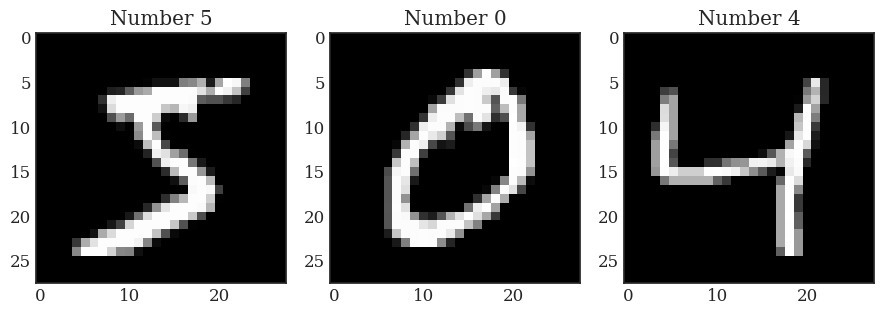

1/1 [==============================] - 0s 19ms/step


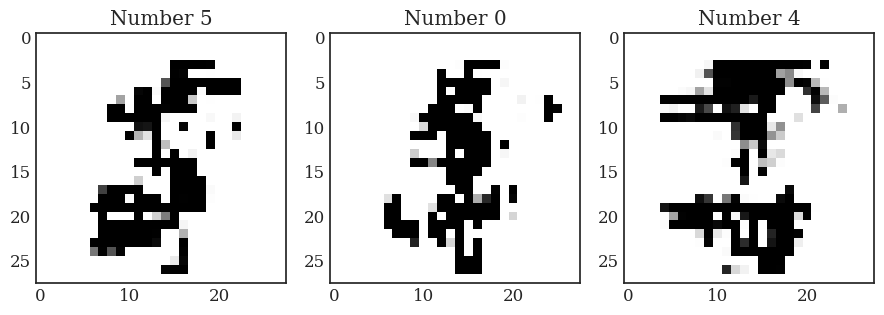

In [87]:
recognition_system = DigitRecognitionSystem(generator_model, embedding_model, 0.25)

digit_1_id = recognition_system.register(X[0])
digit_2_id = recognition_system.register(X[1])
digit_3_id = recognition_system.register(X[2])

print(f'Registered IDs are {digit_1_id}, {digit_2_id}, {digit_3_id}')
show_images(X[:3], y[:3])
show_images(generator_model.predict(X[:3]), y[:3])

In [101]:
class PairValidationGenerator(tf.keras.utils.Sequence):
    def __init__(self, X: list, y: list, positive_classes=[5,0,4]) -> None:
        """
        Initializes pair generator
        """
        assert len(X) == len(y), "The number of images and labels is the same"
        
        self._positive_classes = positive_classes
        self._negative_classes = list(set(list(range(10))).difference(set(positive_classes)))

        unique_labels = np.unique(y)
        self._X_batches = {}
        for y_unique in unique_labels:
            batch = [X[i] for i in range(len(y)) if y[i] == y_unique]
            self._X_batches[y_unique] = batch
    
    def pick(self):
        """
        Generate one batch of data
        """
        
        positive_label = random.choice(self._positive_classes)
        negative_label = random.choice(self._negative_classes)
        return random.choice(self._X_batches[positive_label]), random.choice(self._X_batches[negative_label])

In [127]:
class ClassificationResult:
    def __init__(self, true_positive: int, true_negative: int, false_positive: int, false_negative: int) -> None:
        self._true_positive = true_positive
        self._true_negative = true_negative
        self._false_positive = false_positive
        self._false_negative = false_negative
        
    def precision(self) -> float:
        return self._true_positive / (self._true_positive + self._false_positive)
    
    def recall(self) -> float:
        return self._true_positive / (self._true_positive + self._false_negative)
    
    def f1_score(self) -> float:
        return 2*self._true_positive / (2*self._true_positive + self._false_positive + self._false_negative)
    
    def fpr(self) -> float:
        return self._false_positive / (self._false_positive + self._true_negative)
    
    def tpr(self) -> float:
        return self.recall()   
    
    def draw_summary(self) -> None:
        # Plotting confusion matrix
        confusion_matrix = [
            [self._true_negative, self._false_positive],
            [self._false_negative, self._true_positive]
        ]

        df_cm = pd.DataFrame(confusion_matrix, range(2), range(2))
        sn.set(font_scale=1.4)
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) 
        pyplot.show()
        
        # Printing results
        table = [
            ['Precision', self.precision()],
            ['Recall', self.recall()],
            ['F1 Score', self.f1_score()]
        ]
        print(tabulate(table, headers=['Metrics', 'Score'], tablefmt="grid"))
    
class ClassificationStatistics:
    def __init__(self, results: List[ClassificationResult] = []) -> None:
        self._results = results
        
    def add_result(self, result: ClassificationResult) -> None:
        print(f'inserted tp={result._true_positive}')
        self._results.append(result)
        print(self._results[-1]._true_positive)
        
    def pick_best_f1(self) -> ClassificationResult:
        results_sorted = sorted(self._results, key = lambda x: x.f1_score())
        return results_sorted[-1]
    
    def get_roc_curve_points(self, n_split: int = 300):
        curve_points = []
        for i in range(n_split):
            # Defining the interval
            left_interval = i / n_split
            right_interval = (i + 1) / n_split
            
            # Finding all y's for the given interval
            y_interval = [result.tpr() for result in self._results if left_interval <= result.fpr() <= right_interval]
            if len(y_interval) == 0:
                continue
            
            # Adding a point on the curve
            x_point = (left_interval + right_interval) / 2
            y_point = np.max(y_interval)
            curve_points.append((x_point, y_point))
        
        return curve_points
    
    def display_roc_curve(self, label: str, n_split: int = 300, color: str = 'red'):
        points = self.get_roc_curve_points(n_split=n_split)
        line, = pyplot.step([x for x, _ in points], [y for _, y in points], linewidth=2.5, color=color, label=label)
        return line

In [128]:
def get_statistics(
    recognition_system: DebugDigitRecognitionSystem,
    pair_generator: PairValidationGenerator, 
    pairs_number: int = 100,
    threshold_from: float = 0.0,
    threshold_to: float = 2.0,
    threshold_split: int = 100
) -> ClassificationStatistics:
    """
    Generates a classification statistics based on the specified pair generator and recognition system
    """
    
    # Defining a statistics
    results: List[ClassificationResult] = []
    for threshold in np.linspace(threshold_from, threshold_to, num=threshold_split):
        recognition_system.set_threshold(threshold)

        # true positive, true negative, false positive, false negative
        tp = tn = fp = fn = 0
        for _ in range(pairs_number):
            positive, negative = pair_generator.pick()

            positive_id = recognition_system.login(positive)
            if positive_id == DebugDigitRecognitionSystem.LOGIN_FAILED:
                fn += 1
            else:
                tp += 1

            negative_id = recognition_system.login(negative)
            if negative_id == DebugDigitRecognitionSystem.LOGIN_FAILED:
                tn += 1
            else:
                fp += 1
         
        results.append(ClassificationResult(tp, tn, fp, fn))

    return ClassificationStatistics(results)

In [129]:
# Creating a pair generator
pairs_generator = PairValidationGenerator(X_emb_real, y, positive_classes=[5,0,4])

In [140]:
# Registering a debug recognition system
debug_recognition_system_real = DebugDigitRecognitionSystem(generator_model, embedding_model, 0.25)
debug_recognition_system_real.register_directly(X[0])
debug_recognition_system_real.register_directly(X[1])
debug_recognition_system_real.register_directly(X[2])

# Defining a statistics
statistics_real = get_statistics(debug_recognition_system_real, pairs_generator, pairs_number=1000, threshold_split=1000, threshold_to=3.0)

In [141]:
# Registering a debug recognition system
debug_recognition_system_generated = DebugDigitRecognitionSystem(generator_model, embedding_model, 0.25)
debug_recognition_system_generated.register(X[0])
debug_recognition_system_generated.register(X[1])
debug_recognition_system_generated.register(X[2])

# Defining a statistics
statistics_generated = get_statistics(debug_recognition_system_generated, pairs_generator, pairs_number=1000, threshold_split=1000, threshold_to=3.0)

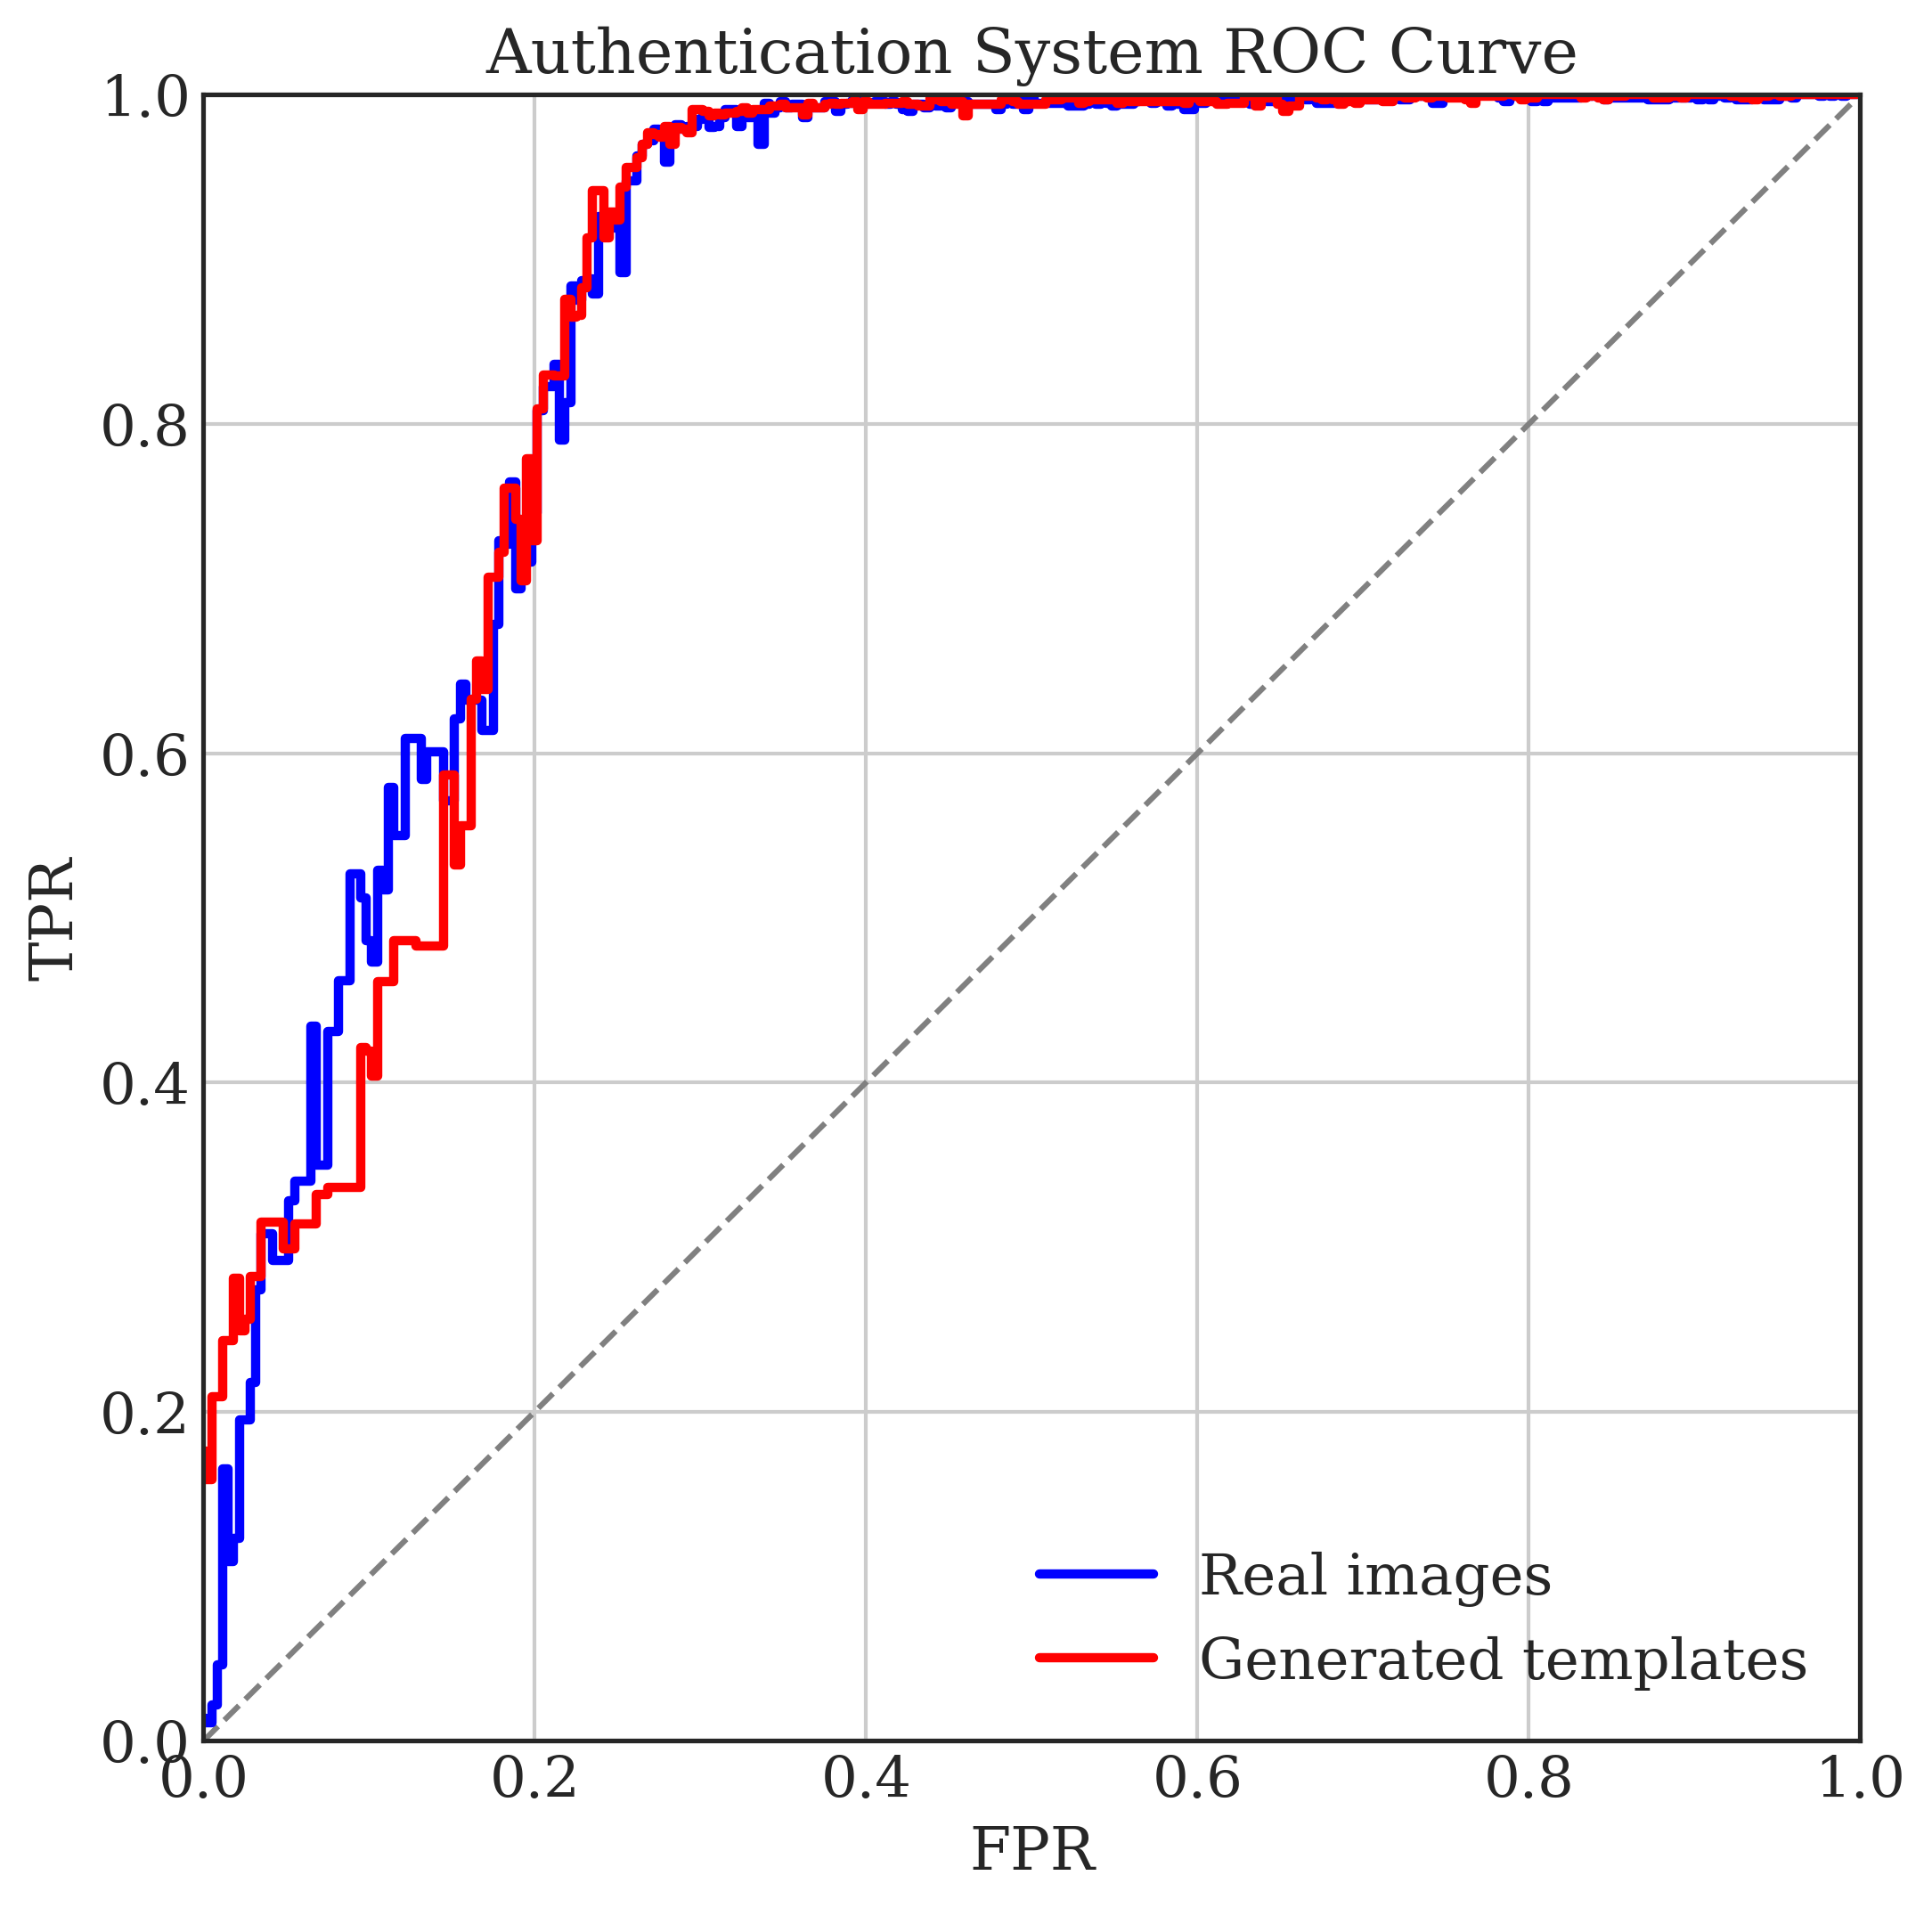

In [142]:
pyplot.style.use('seaborn-v0_8-white') # Choose pyplot styling
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
pyplot.rc('font', **font)
pyplot.rc('axes', labelsize=16)
pyplot.figure(figsize=(8, 8), dpi=300)
pyplot.grid()
pyplot.xlim(0, 1)
pyplot.ylim(0, 1)
pyplot.plot([0.0, 1.0], [0.0, 1.0], linewidth=1.5, color='gray', linestyle='--')
line_1 = statistics_generated.display_roc_curve(label='Real images', n_split=300, color='blue')
line_2 = statistics_real.display_roc_curve(label='Generated templates', n_split=300, color='red')
pyplot.legend(handles=[line_1, line_2])
pyplot.title("Authentication System ROC Curve")
pyplot.xlabel("FPR")
pyplot.ylabel("TPR")
pyplot.savefig('images/evaluation/roc_3.png')
pyplot.show()

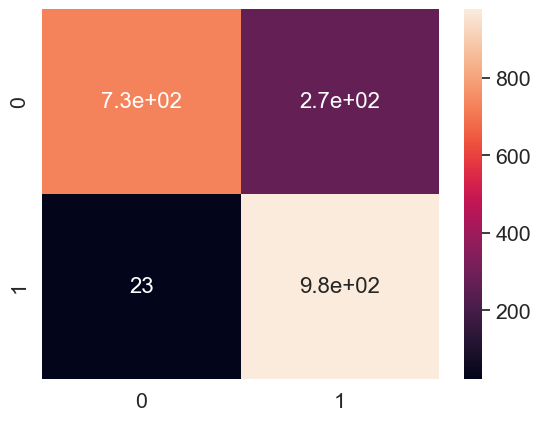

+-----------+----------+
| Metrics   |    Score |
+===========+==========+
| Precision | 0.782226 |
+-----------+----------+
| Recall    | 0.977    |
+-----------+----------+
| F1 Score  | 0.868831 |
+-----------+----------+
TP=977
TN=728
FP=272
FN=23


In [151]:
best_result_real = statistics_real.pick_best_f1()
best_result_real.draw_summary()

logging.info(f'TP={best_result_real._true_positive}')
logging.info(f'TN={best_result_real._true_negative}')
logging.info(f'FP={best_result_real._false_positive}')
logging.info(f'FN={best_result_real._false_negative}')

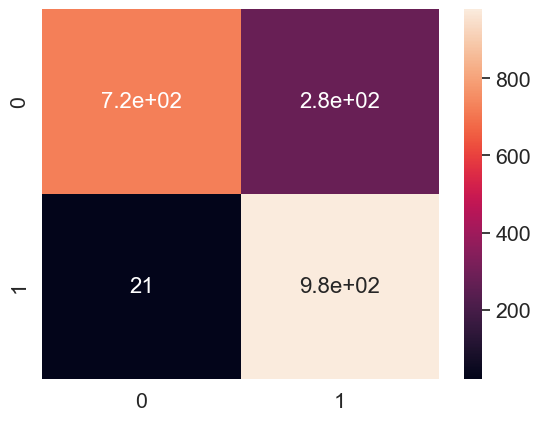

+-----------+----------+
| Metrics   |    Score |
+===========+==========+
| Precision | 0.78008  |
+-----------+----------+
| Recall    | 0.979    |
+-----------+----------+
| F1 Score  | 0.868293 |
+-----------+----------+
TP=979
TN=724
FP=276
FN=21


In [152]:
best_result_generated = statistics_generated.pick_best_f1()
best_result_generated.draw_summary()

logging.info(f'TP={best_result_generated._true_positive}')
logging.info(f'TN={best_result_generated._true_negative}')
logging.info(f'FP={best_result_generated._false_positive}')
logging.info(f'FN={best_result_generated._false_negative}')